In [2]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow

In [3]:
!nvidia-smi

Fri May  6 12:11:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import

In [4]:
import os
import sys
import csv
import pickle
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    Callback, 
    LearningRateScheduler, 
    ModelCheckpoint, 
    EarlyStopping
)
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Фиксируем окружение

In [5]:
!pip freeze > requirements.txt

# Основные настройки

In [6]:
EPOCHS               = 9    # эпох на обучение
BATCH_SIZE           = 9   # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
VAL_SPLIT            = 0.2  # 20% данных выделяем на тест
# ACTIVATION           = 'sigmoid' # функция активации
# ACTIVATION           = 'tanh' # функция активации
# ACTIVATION           = 'relu' # функция активации
ACTIVATION           = L.LeakyReLU(0.2) # функция активации


CLASS_NUM            = 10   # количество классов в нашей задаче
IMG_SIZE             = 331  # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3    # у RGB 3 канала
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# for augmentation
WIDTH_SHIFT_RANGE    = 0.15
HEIGHT_SHIFT_RANGE   = 0.15
HORIZONTAL_FLIP      = True
VERTICAL_FLIP        = False
ROTATION_RANGE       = 15
BRIGHTNES_RANGE      = (0.5, 1.5)
SHEAR_RANGE          = 0.2
ZOOM_RANGE           = 0.15


is_colab = True   # Сменить на False если запускается на Kaggle

In [7]:
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [8]:

if is_colab:
    # Colab
    DATA_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_7/input')
    SAVE_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_7')
    WORK_PATH = os.path.join(os.getcwd(), 'working', 'car')
else:
    # Kaggle
    DATA_PATH = os.path.abspath('../input/car-classification')
    SAVE_PATH = os.path.abspath('../input/saves-models')
    WORK_PATH = os.path.abspath('./')

In [9]:
# создаём рабочую директорию
if is_colab:
    os.makedirs(WORK_PATH, exist_ok=True)

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 12
# np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Версии

In [10]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.21.6
Tensorflow   : 2.8.0
Keras        : 2.8.0


# Вспомогательные функции

In [11]:
def get_model(base_model):
    model=M.Sequential()
    model.add(base_model)

    # model layer 1
    model.add(L.Convolution2D(128, (3, 3), input_shape=INPUT_SHAPE, 
                              activation=ACTIVATION, padding='same',))
    model.add(L.BatchNormalization())

    # Pooling layer 1
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.2))

    # model layer 2
    model.add(L.Convolution2D(256, (3, 3), activation=ACTIVATION, 
                              padding='same',))
    model.add(L.BatchNormalization())

    # Pooling layer 2
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.25))

    # model layer 3.
    model.add(L.Convolution2D(512, (3, 3), activation=ACTIVATION, 
                              padding='same',))
    model.add(L.BatchNormalization())

    # Pooling layer 3
    model.add(L.MaxPooling2D(pool_size=(2,2)))
    model.add(L.Dropout(0.3))

    # Flattening
    model.add(L.Flatten())

    # Full connection
    model.add(L.Dense(512, activation=ACTIVATION))
    model.add(L.Dense(256, activation=ACTIVATION))
    model.add(L.Dropout(0.3))
    model.add(L.Dense(CLASS_NUM, activation='softmax'))

    return model

def fit_model(model, cb_list, epochs=EPOCHS):
    return model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = epochs,
        callbacks = cb_list
    )


In [12]:
def veiw_random_images(random_image_paths, random_image_cat):
    for index, path in enumerate(random_image_paths):
        if is_colab:
            im = PIL.Image.open(os.path.join(WORK_PATH, 'train', 
                                             str(random_image_cat[index]), 
                                             str(path)))
        else:
            im = PIL.Image.open(os.path.join(DATA_PATH, 'train', 'train', 
                                             str(random_image_cat[index]), 
                                             str(path)))

        plt.subplot(3,3, index+1)
        plt.subplots_adjust(hspace=0.5)
        plt.imshow(im)
        plt.title('Class: ' + str(random_image_cat[index]))
    plt.show()

In [13]:
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [14]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    #plt.style.use('dark_background')
    plt.legend()

    plt.show()


# EDA / Анализ данных

In [15]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 
                                             'sample-submission.csv'))

In [16]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [18]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

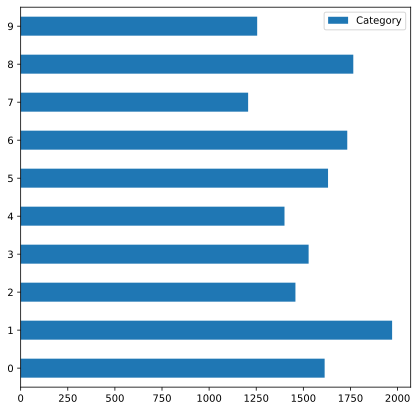

In [19]:
pd.DataFrame(train_df['Category'].value_counts(sort=False)).plot(kind='barh', 
                                                                 figsize=(7, 7))

Распределение классов достаточно равномерное.

In [20]:
if is_colab:
    print('Распаковываем картинки')
    for data_zip in ['train.zip', 'test.zip']:
        with zipfile.ZipFile(os.path.join(DATA_PATH, data_zip),"r") as z:
            z.extractall(WORK_PATH)
            
    print(os.listdir(WORK_PATH))

Распаковываем картинки
['test_upload', 'train']


Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжать.

Пример картинок


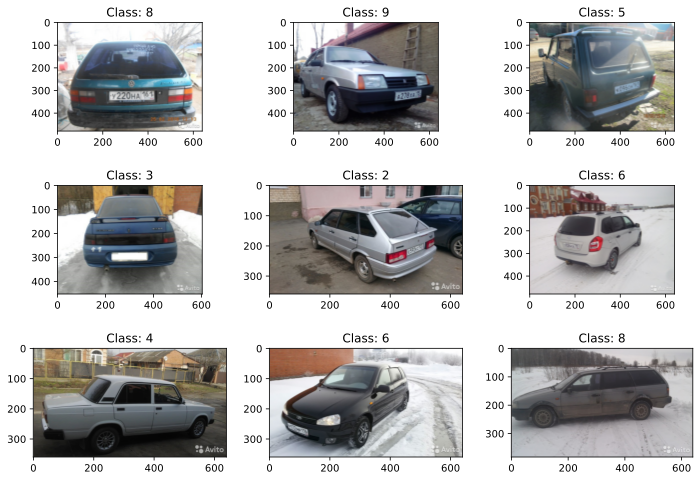

In [21]:
print('Пример картинок')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Изображения вполне различимы. Имеют разный размер.

Посмотрим на изображения одного класса.

Пример картинок одного класса


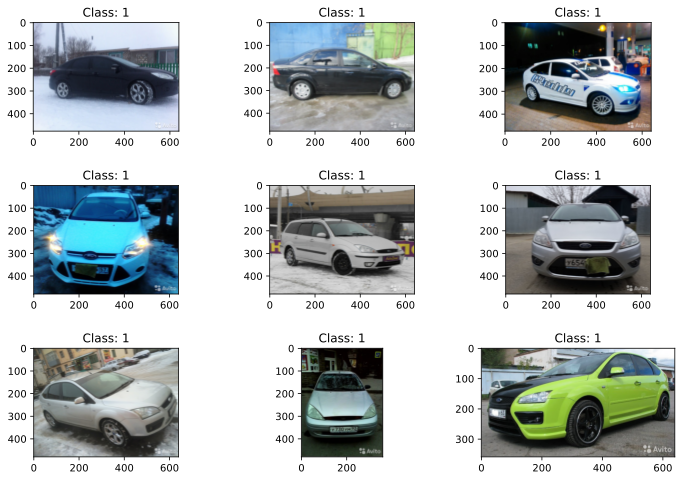

In [22]:
print('Пример картинок одного класса')
plt.figure(figsize=(12,8))

random_image = train_df.loc[train_df['Category'] == 1].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

veiw_random_images(random_image_paths, random_image_cat)

Очевидно что класс это модель автомобиля. 

# Подготовка данных

### Аугментация данных

Т.к. данных относительно не много, следует прибегнуть к аугментации данных.  
Чтобы экономить ресурсы железа создадим генератор, который будет подавать в модель изображения порциями.  
За аугментацию так же будет отвечать генератор.  

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = ROTATION_RANGE,
    brightness_range=BRIGHTNES_RANGE,
    shear_range=SHEAR_RANGE,
    zoom_range=ZOOM_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    validation_split=VAL_SPLIT,
    horizontal_flip=HORIZONTAL_FLIP
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [24]:
# Завернем наши данные в генератор:
if is_colab:
    train_path = os.path.join(WORK_PATH, 'train')
    test_path = os.path.join(WORK_PATH, 'test_upload')
else:
    train_path = os.path.join(DATA_PATH, 'train', 'train')
    test_path = os.path.join(DATA_PATH, 'test', 'test_upload')

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=test_path,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Данные разбиты корректно: в каждой группе равное количество классов.

# Посмотрим аугментацию данных.

Пример аугментированных картинок из train_generator


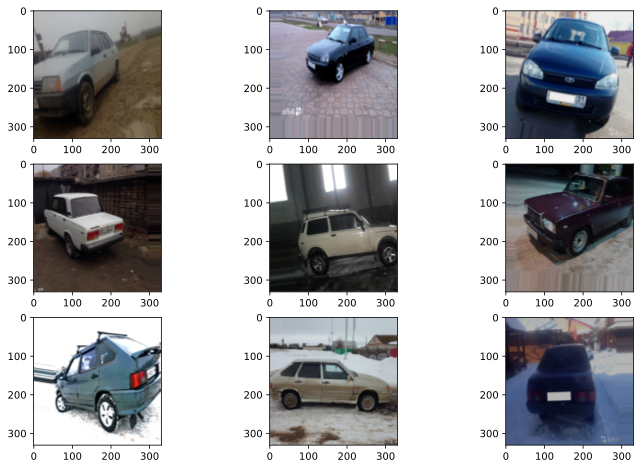

In [25]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next()
print('Пример аугментированных картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

В качестве подопытных были выбраны следующие модели:


Создадим датаврейм в который будем заносить accuracy и loss для удобства сравнения.

In [26]:
model_indicators = pd.DataFrame(['model', 'accuracy', 'loss'])

In [27]:
raise KeyboardInterrupt

KeyboardInterrupt: ignored

# Обучение моделей

### Сеть Xception.

### Этап 1.

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape = INPUT_SHAPE)

In [ ]:
LR=0.001
file_name = 'XC_model'

base_model.trainable = False

XC_model = get_model(base_model)

XC_model.compile(loss="categorical_crossentropy", 
                 optimizer=optimizers.Adam(learning_rate=LR), 
                 metrics=["accuracy"])

In [ ]:
if is_colab:
    cb_checkpoint = ModelCheckpoint(os.path.join(SAVE_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')
else:
    cb_checkpoint = ModelCheckpoint(os.path.join(WORK_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')

cb_earlystop = EarlyStopping(monitor='accuracy', patience=3, verbose=1, restore_best_weights=True)
cb_schedul = LearningRateScheduler(scheduler)

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]

In [ ]:
# raise KeyboardInterrupt

Обучаем.

In [ ]:
history = fit_model(XC_model, callbacks_list)

In [ ]:
if is_colab:
    XC_model.save(os.path.join(SAVE_PATH, file_name+'_step1.hdf5'))
    XC_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    XC_model.save(os.path.join(WORK_PATH, file_name+'_step1.hdf5'))
    XC_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))


In [ ]:
scores = XC_model.evaluate_generator(test_generator, 
                                  steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Посмотрим график обучения.

In [ ]:
plot_history(history)

На данном этапе модель уже показывает хорошие результаты.

In [ ]:
# raise KeyboardInterrupt

### Этап 2.  
Обучаем половину слоёв.

In [ ]:
LR=0.0001

In [ ]:
# Раскомментировать при обрыве обучения
# XC_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step1.hdf5'))
# XC_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR),
#                    metrics=["accuracy"])


Разморозим половину слоёв.

In [ ]:
base_model.trainable = True

# находим половину слоёв
fine_tune_at = len(base_model.layers)//2

# замораживаем половину слоёв
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

XC_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])


Обучаем.

In [ ]:
history = fit_model(XC_model, callbacks_list)

In [ ]:
if is_colab:
    XC_model.save(os.path.join(SAVE_PATH, file_name+'_step2.hdf5'))
    XC_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    XC_model.save(os.path.join(WORK_PATH, file_name+'_step2.hdf5'))
    XC_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

In [ ]:
scores = XC_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

Разблокировка половины слоёв привела к улучшению предсказательной способности модели.

In [ ]:
# raise KeyboardInterrupt

### Этап 3.
Обучаем все слои.

In [ ]:
LR=0.00001

In [ ]:
# Раскомментировать при обрыве обучения
# XC_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step2.hdf5'))
# XC_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR),
#                    metrics=["accuracy"])


In [ ]:
base_model.trainable = True

XC_model.compile(loss="categorical_crossentropy", 
                 optimizer=optimizers.Adam(learning_rate=LR), 
                 metrics=["accuracy"])

In [ ]:
history = fit_model(XC_model, callbacks_list)

In [ ]:
if is_colab:
    XC_model.save(os.path.join(SAVE_PATH, file_name+'_step3.hdf5'))
    XC_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    XC_model.save(os.path.join(WORK_PATH, file_name+'_step3.hdf5'))
    XC_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))


In [ ]:
XC_model = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                      file_name+'_step2.hdf5'))

In [ ]:
scores = XC_model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
plot_history(history)

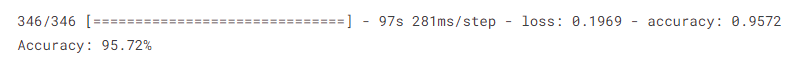

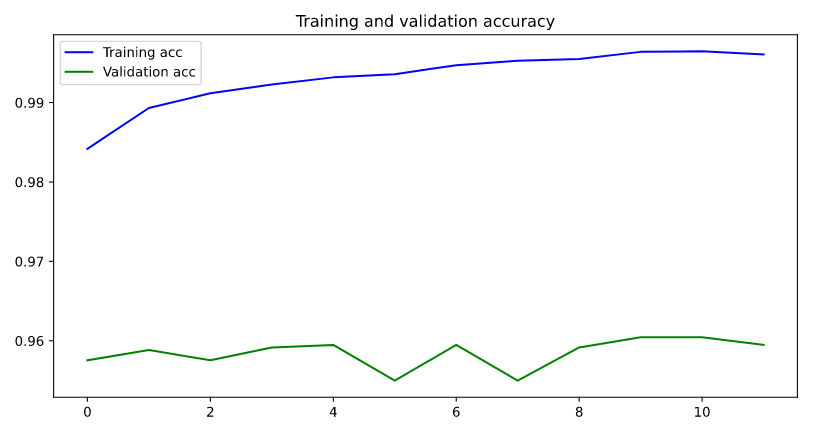

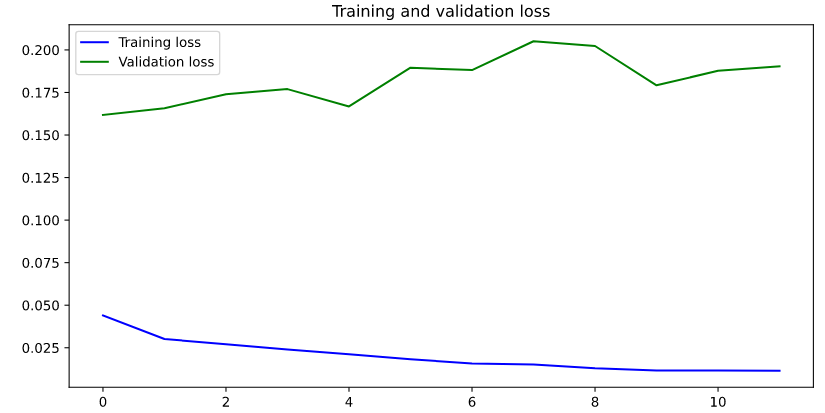

Точность - 95.72%. Loss - 0.1969.  
Данная модель переобучилась, однако всё же показывает неплохой результат.

In [ ]:
# raise KeyboardInterrupt

### Сеть MobileNetV2

In [28]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=INPUT_SHAPE)

LR=0.001
file_name = 'MNV2_model'

base_model.trainable = False

MNV2_model = get_model(base_model)

MNV2_model.compile(loss="categorical_crossentropy", 
                   optimizer=optimizers.Adam(learning_rate=LR), 
                   metrics=["accuracy"])

if is_colab:
    cb_checkpoint = ModelCheckpoint(os.path.join(SAVE_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')
else:
    cb_checkpoint = ModelCheckpoint(os.path.join(WORK_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')

cb_earlystop = EarlyStopping(monitor='accuracy', patience=3, 
                             verbose=1, restore_best_weights=True)
cb_schedul = LearningRateScheduler(scheduler)

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]


9420800/9406464 [==============================] - 0s 0us/step


### Этап 1.

Epoch 1/9
1384/1384 [==============================] - ETA: 0s - loss: 1.6050 - accuracy: 0.4351
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/MNV2_model_best.hdf5
1384/1384 [==============================] - 600s 424ms/step - loss: 1.6050 - accuracy: 0.4351 - val_loss: 1.0996 - val_accuracy: 0.5954 - lr: 0.0010
Epoch 2/9
1384/1384 [==============================] - ETA: 0s - loss: 1.1054 - accuracy: 0.6099
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/MNV2_model_best.hdf5
1384/1384 [==============================] - 563s 407ms/step - loss: 1.1054 - accuracy: 0.6099 - val_loss: 0.8563 - val_accuracy: 0.7002 - lr: 0.0010
Epoch 3/9
1384/1384 [==============================] - ETA: 0s - loss: 0.9091 - accuracy: 0.6767
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/MNV2_model_best.hdf5
1384/1384 [==============================] - 564s 407ms/step - loss: 0.9091 - accuracy: 0.6767 - val_loss: 0.8998 - val_accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


346/346 [==============================] - 111s 321ms/step - loss: 0.5602 - accuracy: 0.8073
Accuracy: 80.73%


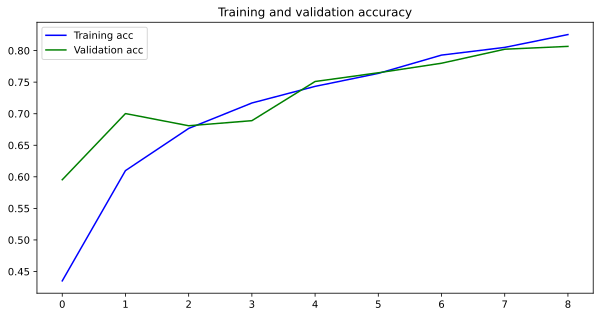

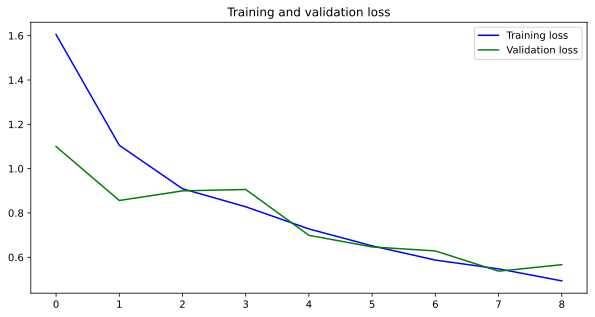

In [29]:
history = fit_model(MNV2_model, callbacks_list)

if is_colab:
    MNV2_model.save(os.path.join(SAVE_PATH, file_name+'_step1.hdf5'))
    MNV2_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    MNV2_model.save(os.path.join(WORK_PATH, file_name+'_step1.hdf5'))
    MNV2_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = MNV2_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)


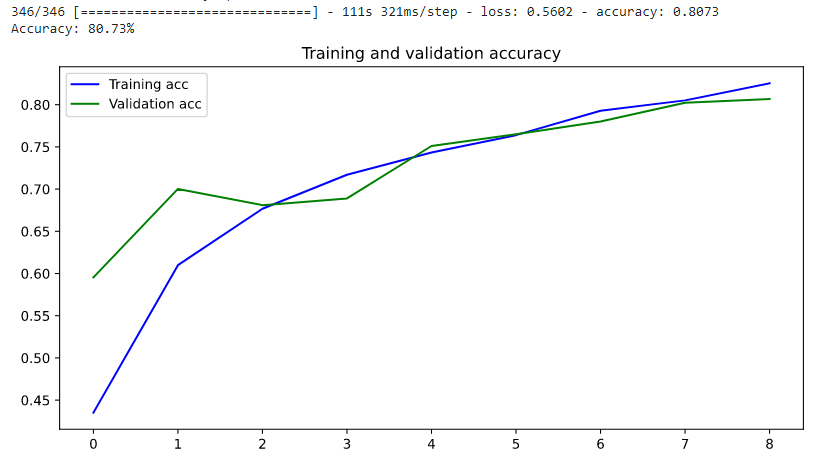

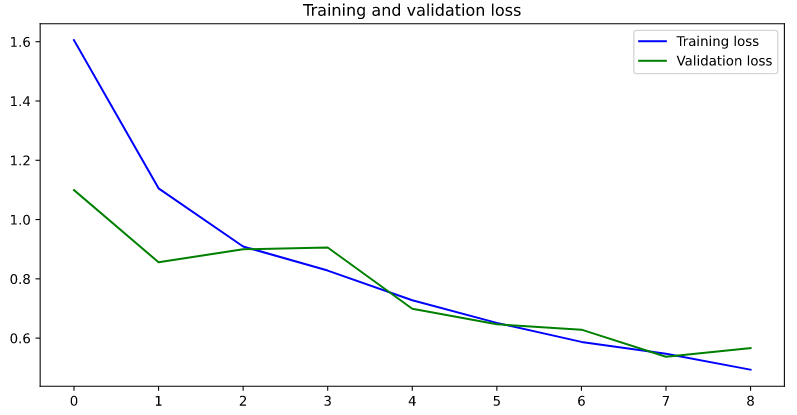

In [30]:
# raise KeyboardInterrupt

### Этап 2.

Epoch 1/9
1384/1384 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.7792
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/MNV2_model_best.hdf5
1384/1384 [==============================] - 584s 418ms/step - loss: 0.6287 - accuracy: 0.7792 - val_loss: 0.5088 - val_accuracy: 0.8212 - lr: 1.0000e-04
Epoch 2/9
1384/1384 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8734
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/MNV2_model_best.hdf5
1384/1384 [==============================] - 582s 420ms/step - loss: 0.3523 - accuracy: 0.8734 - val_loss: 0.3059 - val_accuracy: 0.8945 - lr: 1.0000e-04
Epoch 3/9
1384/1384 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.9017
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/MNV2_model_best.hdf5
1384/1384 [==============================] - 576s 416ms/step - loss: 0.2782 - accuracy: 0.9017 - val_loss: 0.3431 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


346/346 [==============================] - 112s 322ms/step - loss: 0.1842 - accuracy: 0.9399
Accuracy: 93.99%


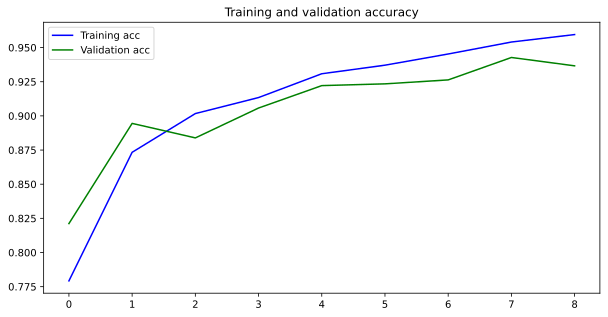

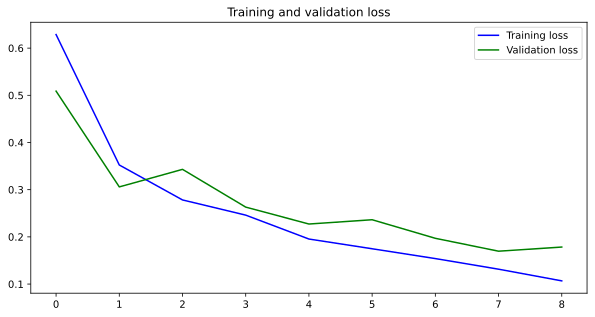

In [31]:
LR=0.0001

################################################################################
# Раскомментировать при обрыве обучения
# MNV2_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step1.hdf5'))
# MNV2_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR), 
#                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

# находим половину слоёв
fine_tune_at = len(base_model.layers)//2

# замораживаем половину слоёв
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

MNV2_model.compile(loss="categorical_crossentropy", 
                   optimizer=optimizers.Adam(learning_rate=LR), 
                   metrics=["accuracy"])


history = fit_model(MNV2_model, callbacks_list)

if is_colab:
    MNV2_model.save(os.path.join(SAVE_PATH, file_name+'_step2.hdf5'))
    MNV2_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    MNV2_model.save(os.path.join(WORK_PATH, file_name+'_step2.hdf5'))
    MNV2_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = MNV2_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

 

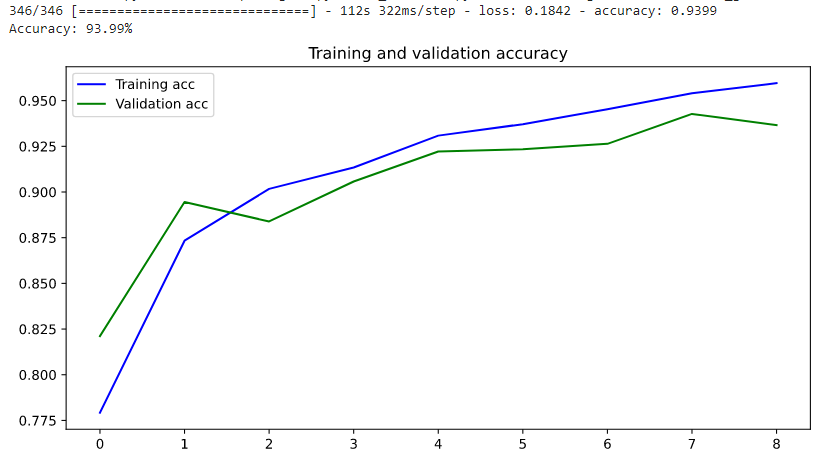

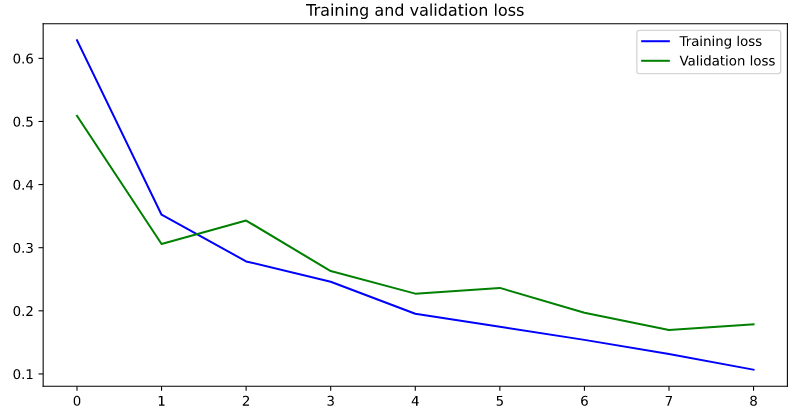

### Этап 3.

In [ ]:
LR=0.00001

################################################################################
# # Раскомментировать при обрыве обучения
# MNV2_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step2.hdf5'))
# MNV2_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR), 
#                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

MNV2_model.compile(loss="categorical_crossentropy", 
                   optimizer=optimizers.Adam(learning_rate=LR), 
                   metrics=["accuracy"])


history = fit_model(MNV2_model, callbacks_list, epochs=12)

if is_colab:
    MNV2_model.save(os.path.join(SAVE_PATH, file_name+'_step3.hdf5'))
    MNV2_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    MNV2_model.save(os.path.join(WORK_PATH, file_name+'_step3.hdf5'))
    MNV2_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = MNV2_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)


Epoch 1/12
1384/1384 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9586
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/MNV2_model_best.hdf5
1384/1384 [==============================] - 669s 479ms/step - loss: 0.1170 - accuracy: 0.9586 - val_loss: 0.1623 - val_accuracy: 0.9460 - lr: 1.0000e-05
Epoch 2/12
1384/1384 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9653
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/MNV2_model_best.hdf5
1384/1384 [==============================] - 660s 477ms/step - loss: 0.0977 - accuracy: 0.9653 - val_loss: 0.1493 - val_accuracy: 0.9521 - lr: 1.0000e-05
Epoch 3/12
1384/1384 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9664
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/project_7/MNV2_model_best.hdf5
1384/1384 [==============================] - 665s 480ms/step - loss: 0.0860 - accuracy: 0.9664 - val_loss: 0.1468

In [ ]:
MNV2_model = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                      file_name+'_best.hdf5'))

scores = MNV2_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

model_indicators['model'] = file_name
model_indicators['accuracy'] = scores[1]*100
model_indicators['loss'] = 

Точность - %. Loss - .

In [ ]:
raise KeyboardInterrupt

### Сеть NASNetLarge

In [ ]:
LR=0.001

file_name = 'NASNL_model'

base_model = tf.keras.applications.NASNetLarge(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=INPUT_SHAPE)

base_model.trainable = False

NASNL_model = get_model(base_model)

NASNL_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

if is_colab:
    cb_checkpoint = ModelCheckpoint(
        os.path.join(SAVE_PATH, file_name+'_best.hdf5'), 
        monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
else:
    cb_checkpoint = ModelCheckpoint(
        os.path.join(WORK_PATH, file_name+'_best.hdf5'),
         monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

cb_earlystop = EarlyStopping(monitor='accuracy', patience=3,
                             verbose=1, restore_best_weights=True)
cb_schedul = LearningRateScheduler(scheduler)

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]


In [ ]:
# raise KeyboardInterrupt

### Этап 1.

In [ ]:
history = fit_model(NASNL_model, callbacks_list)

if is_colab:
    NASNL_model.save(os.path.join(SAVE_PATH, file_name+'_step1.hdf5'))
    NASNL_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    NASNL_model.save(os.path.join(WORK_PATH, file_name+'_step1.hdf5'))
    NASNL_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))


scores = NASNL_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)


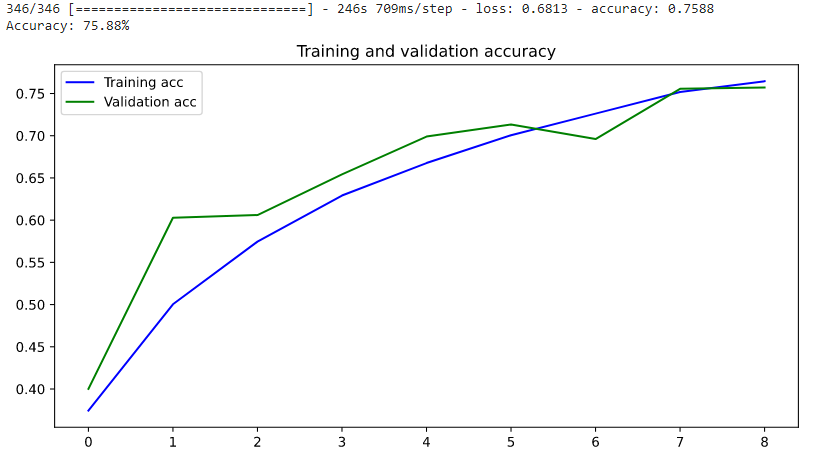

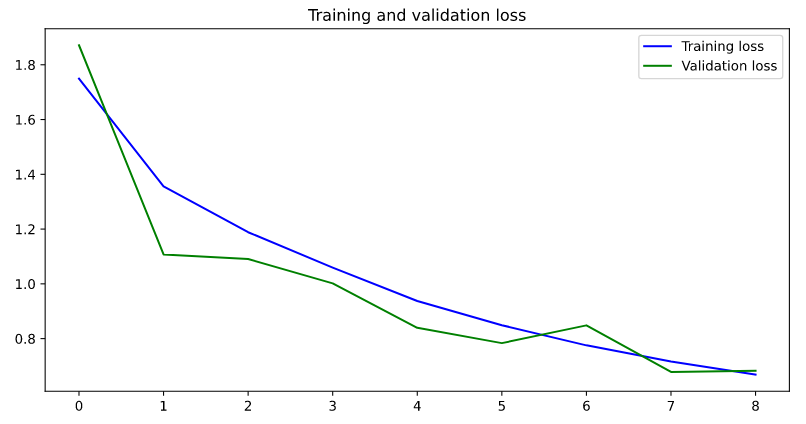

In [ ]:
# raise KeyboardInterrupt

### Этап 2.

In [ ]:
LR=0.0001

################################################################################
# # Раскомментировать при обрыве обучения
# NASNL_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                        file_name+'_step1.hdf5'))

# NASNL_model.compile(loss="categorical_crossentropy", 
#                     optimizer=optimizers.Adam(learning_rate=LR), 
#                     metrics=["accuracy"])
################################################################################

base_model.trainable = True

# находим половину слоёв
fine_tune_at = len(base_model.layers)//2

# замораживаем половину слоёв
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

NASNL_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

history = fit_model(NASNL_model, callbacks_list)

if is_colab:
    NASNL_model.save(os.path.join(SAVE_PATH, file_name+'_step2.hdf5'))
    NASNL_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    NASNL_model.save(os.path.join(WORK_PATH, file_name+'_step2.hdf5'))
    NASNL_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = NASNL_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

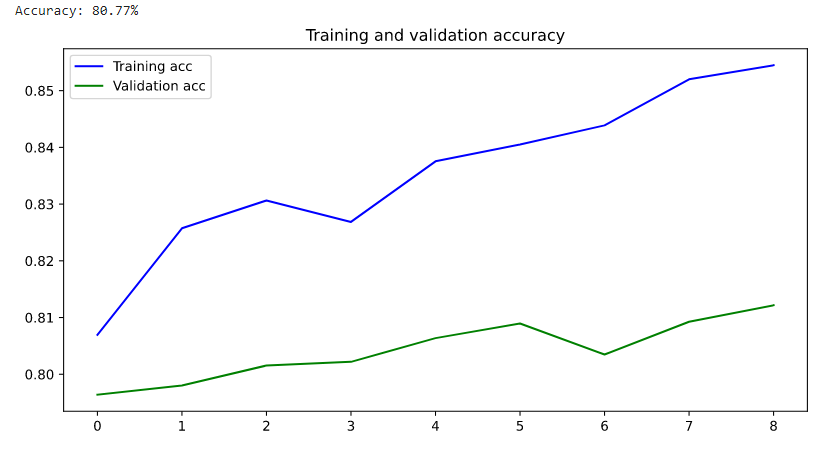

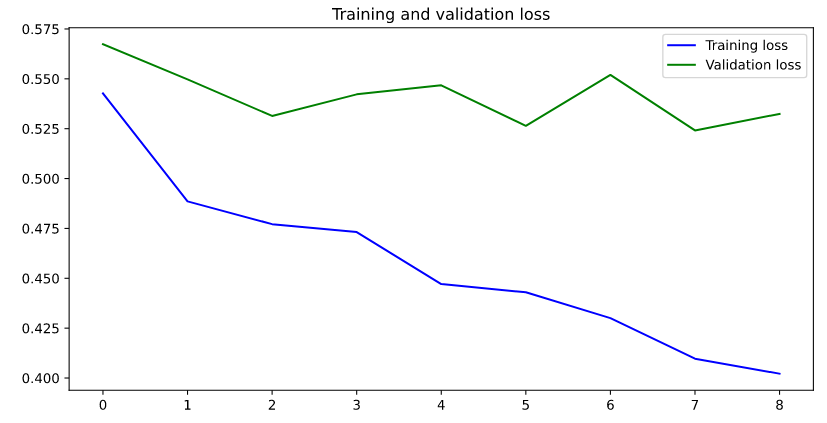

In [ ]:
# raise KeyboardInterrupt

### Этап 3

In [ ]:
LR=0.00001

################################################################################
# # Раскомментировать при обрыве обучения
# NASNL_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'_step2.hdf5'))
#
# NASNL_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR),
#                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

NASNL_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

history = fit_model(NASNL_model, callbacks_list, epochs=12)

if is_colab:
    NASNL_model.save(os.path.join(SAVE_PATH, file_name+'_step3.hdf5'))
    NASNL_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    NASNL_model.save(os.path.join(WORK_PATH, file_name+'_step3.hdf5'))
    NASNL_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = NASNL_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

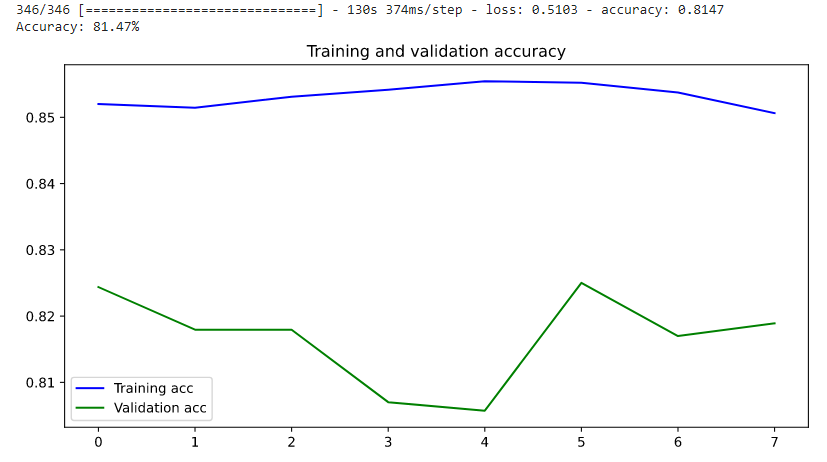

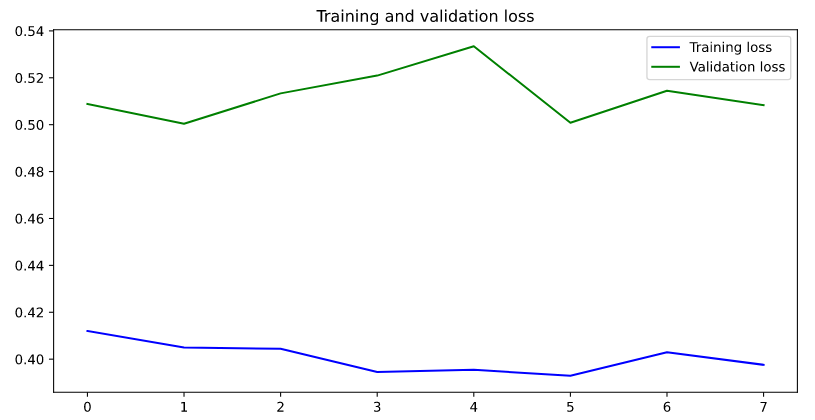

Точность - 81,47%. Loss - 0,5103.  
Данная модель справилась с этой задачей хуже всех. Возможно для неё нужна более серьёзная аугментация, возможно нужно больше эпох и этапов разблокировки слоёв. Возможно нужно больше данных.

In [ ]:
# raise KeyboardInterrupt

### Сеть DenseNet201

In [ ]:
LR=0.001

file_name = 'DN201_model'

base_model = tf.keras.applications.DenseNet201(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=INPUT_SHAPE)

DN201_model = get_model(base_model)

base_model.trainable = False

DN201_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR), 
                    metrics=["accuracy"])

if is_colab:
    cb_checkpoint = ModelCheckpoint(os.path.join(SAVE_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')
else:
    cb_checkpoint = ModelCheckpoint(os.path.join(WORK_PATH, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_accuracy'], 
                                    verbose = 1, mode = 'max')

cb_earlystop = EarlyStopping(monitor='accuracy', patience=3, verbose=1, restore_best_weights=True)
cb_schedul = LearningRateScheduler(scheduler)

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]


In [ ]:
# raise KeyboardInterrupt

### Этап 1

In [ ]:
history = fit_model(DN201_model, callbacks_list)

if is_colab:
    DN201_model.save(os.path.join(SAVE_PATH, file_name+'_step1.hdf5'))
    DN201_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    DN201_model.save(os.path.join(WORK_PATH, file_name+'_step1.hdf5'))
    DN201_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))


scores = DN201_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)


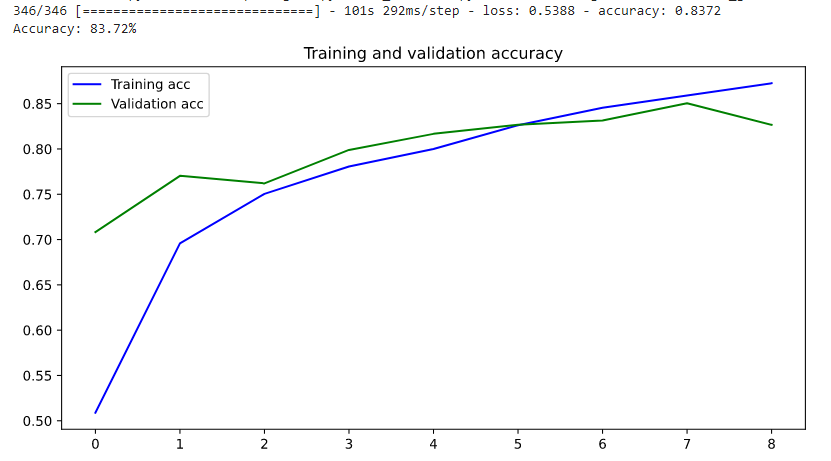

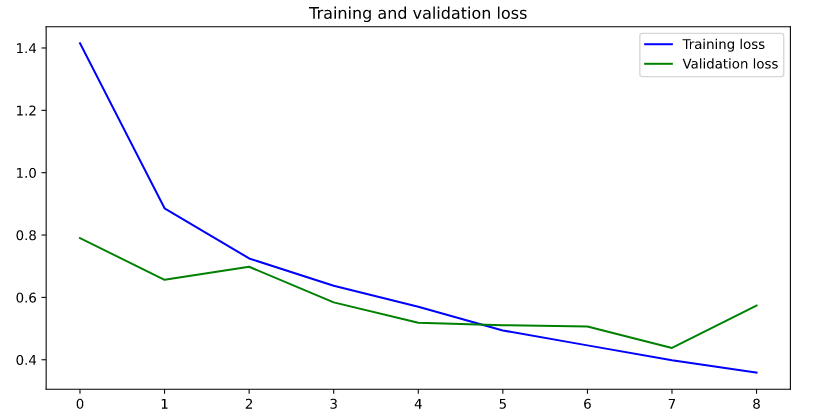

In [ ]:
# raise KeyboardInterrupt

### Этап 2

In [ ]:
LR=0.0001

################################################################################
# # Раскомментировать при обрыве обучения
# DN201_model = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                      file_name+'_step1.hdf5'))
#
# DN201_model.compile(loss="categorical_crossentropy", 
#                    optimizer=optimizers.Adam(learning_rate=LR),
#                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

# находим половину слоёв
fine_tune_at = len(base_model.layers)//2

# замораживаем половину слоёв
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


DN201_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

history = fit_model(DN201_model, callbacks_list)

if is_colab:
    DN201_model.save(os.path.join(SAVE_PATH, file_name+'_step2.hdf5'))
    DN201_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    DN201_model.save(os.path.join(WORK_PATH, file_name+'_step2.hdf5'))
    DN201_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = DN201_model.evaluate_generator(test_generator, verbose=1)

print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

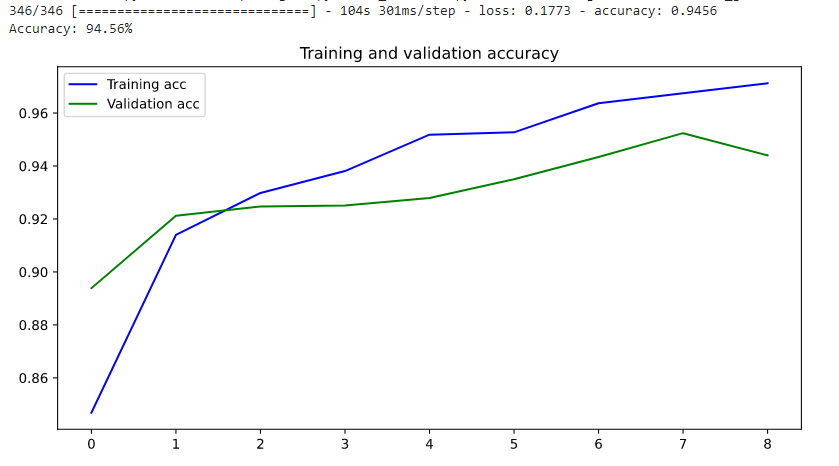

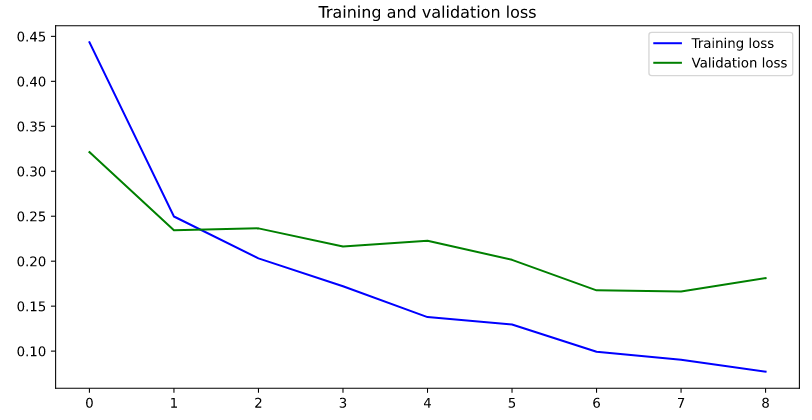

In [ ]:
# raise KeyboardInterrupt

### Этап 3

In [ ]:
LR=0.00001

###############################################################################
# Раскомментировать при обрыве обучения
DN201_model = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                       file_name+'_step2.hdf5'))
DN201_model.compile(loss="categorical_crossentropy", 
                   optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])
################################################################################

base_model.trainable = True

DN201_model.compile(loss="categorical_crossentropy", 
                    optimizer=optimizers.Adam(learning_rate=LR),
                    metrics=["accuracy"])

history = fit_model(DN201_model, callbacks_list, epochs=12)

if is_colab:
    DN201_model.save(os.path.join(SAVE_PATH, file_name+'_step3.hdf5'))
    DN201_model.load_weights(os.path.join(SAVE_PATH, file_name+'_best.hdf5'))
else:
    DN201_model.save(os.path.join(WORK_PATH, file_name+'_step3.hdf5'))
    DN201_model.load_weights(os.path.join(WORK_PATH, file_name+'_best.hdf5'))

scores = DN201_model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

plot_history(history)

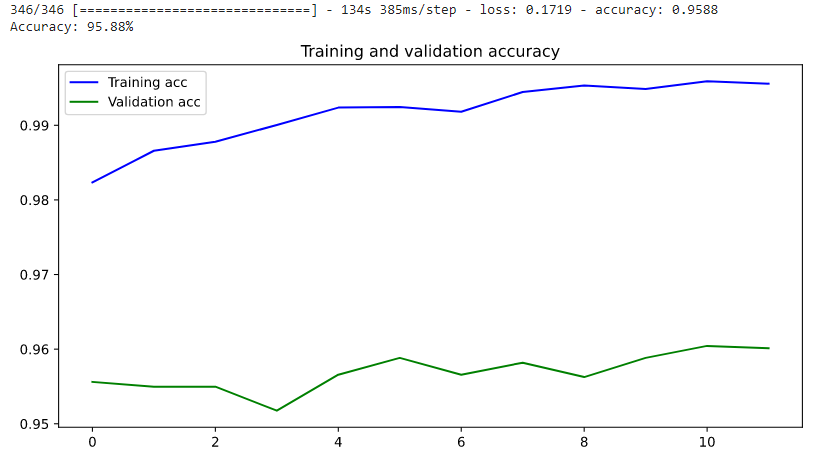

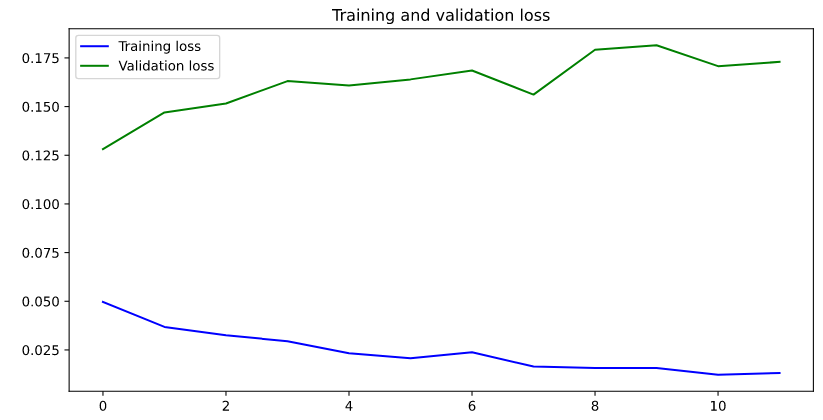

Точность 95.88%, Loss - 0.1719.  

In [ ]:
raise KeyboardInterrupt

В качестве итоговой модели выберем .  
В идеале стоит объединить все модели в ансамбль по принципу мажоритарного голосования, но времени на дообучение не хватит, поэтому ограничимся только TTA.

# Предсказание на тестовых данных

In [ ]:
# Подгрузить рабочую модель
final_model = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                   'DN201_model_best.hdf5'))

In [ ]:
# test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = final_model.predict(test_sub_generator, 
                                      steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())
predictions = [label_map[k] for k in predictions]

filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], 
                          index=filenames_with_dir)
test_files.index = test_files['Id']
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, 
                  sort=False)

print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], 
                                           tmp_y['Predict'],)*100))

# TTA

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range = 90,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,)

tta_steps = 12
predictions = []

for i in range(tta_steps):
    preds = final_model.predict(test_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())
predictions = [label_map[k] for k in predictions]

filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], 
                          index=filenames_with_dir)
tmp_y = pd.concat([submission['Predict'], test_files['Category']], 
                  axis=1, sort=False)

# Submission

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(os.path.join(SAVE_PATH, 'car_classif_submission.csv'), 
                  index=False)